# Importing Dependencies

In [9]:
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, GRU, BatchNormalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import glob
import os

# Loading Dataset

In [10]:
# original = pl.read_csv("Entire_Dataset/UNSW_2018_IoT_Botnet_Dataset_1.csv", n_rows=0)
# merged = pl.read_csv("Final_Merged_Dataset.csv", n_rows=0, ignore_errors=True)

# missing = set(original.columns) - set(merged.columns)
# print(missing)


In [11]:
cols = pl.read_csv('Bot_Iot_final_scaled.csv', n_rows=0, ignore_errors=True).columns

schema_overide = {c: pl.Float64 for c in cols if c!="attack"}
schema_overide["attack"] = pl.Int8

df = pl.scan_csv("Bot_Iot_final_scaled.csv", infer_schema_length=None)

In [12]:
print(cols)

['pkSeqID', 'stime', 'sport', 'dport', 'pkts', 'bytes', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack', 'flgs_eU', 'flgs_e_dS', 'flgs_e_&', 'flgs_e_r', 'flgs_e', 'flgs_e___t', 'flgs_e__D', 'flgs_e____F', 'flgs_e_d', 'flgs_e_g', 'flgs_e_*', 'flgs_e_s', 'flgs_e_dD', 'proto_igmp', 'proto_tcp', 'proto_ipv6-icmp', 'proto_arp', 'proto_rarp', 'proto_udp', 'proto_icmp', 'state_NRS', 'state_TST', 'state_INT', 'state_ECO', 'state_MAS', 'state_CON', 'state_ACC', 'state_CLO', 'state_REQ', 'state_URP', 'state_FIN', 'state_RST', 'state_PAR', 'state_RSP', 'saddr_1', 'saddr_2', 'saddr_3', 'saddr_4', 'daddr_1', 'daddr_2', 'daddr_3', 'daddr_4']


In [13]:
# pl.read_csv("Bot_Iot_final_scaled.csv", n_rows=0).columns

In [14]:
# target_counts = (
#     df.select(pl.col("attack").value_counts())
#     .collect()
# )
# print(target_counts)

In [15]:
# total_rows = df.select(pl.len()).collect().item()
# split_idx = int(total_rows * 0.8)

In [16]:
# train_df = df.slice(0, split_idx)
# test_df  = df.slice(split_idx, total_rows - split_idx)

In [17]:
LABEL_COL = 'attack'
BATCH_SIZE = 1024
WINDOW = 20
MODEL_BATCH = 64

FEATURE_COLS = [c for c in cols if c != LABEL_COL]
SELECTED_COLS = FEATURE_COLS + [LABEL_COL]
NUM_FEATURES = len(FEATURE_COLS)


def get_dataset(file_path):

    column_defaults = []

    for col in SELECTED_COLS:
        if col == LABEL_COL:
            column_defaults.append(tf.float32)
        else:
            column_defaults.append(tf.float32)

    return tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=BATCH_SIZE,
        label_name=LABEL_COL,
        select_columns=SELECTED_COLS,
        column_defaults=column_defaults,
        na_value ="?",
        num_epochs=1,
        shuffle=False,
        ignore_errors = True
    )


def pack(features, label):
    x = tf.stack(
        [tf.cast(features[col], tf.float32) for col in FEATURE_COLS],
        axis=1
    )
    return x, tf.cast(label, tf.float32)


def build_pipeline(file_path):

    dataset = get_dataset(file_path)
    dataset = dataset.map(pack)

    dataset = dataset.unbatch()

    dataset = dataset.window(WINDOW, shift=WINDOW, drop_remainder=True)

    dataset = dataset.flat_map(
        lambda x, y: tf.data.Dataset.zip((
            x.batch(WINDOW),
            y.batch(WINDOW)
        ))
    )

    dataset = dataset.map(lambda x, y: (x, y[-1]))

    dataset = dataset.batch(MODEL_BATCH, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


train_dataset = build_pipeline("train.csv")
test_dataset  = build_pipeline("test.csv")

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [18]:
for x, y in train_dataset.take(1):
    print("X shape:", x.shape)
    print("Y shape:", y.shape)

X shape: (64, 20, 63)
Y shape: (64,)


2026-02-25 05:29:36.133628: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
print("Train cardinality:", tf.data.experimental.cardinality(train_dataset))
print("Test cardinality:", tf.data.experimental.cardinality(test_dataset))

Train cardinality: tf.Tensor(-2, shape=(), dtype=int64)
Test cardinality: tf.Tensor(-2, shape=(), dtype=int64)


# Model Training

In [36]:
train_dataset = build_pipeline('train.csv')
test_dataset = build_pipeline('test.csv')

In [60]:
for x, y in train_dataset.take(1):
    print("X shape:", x.shape)
    print("Y shape:", y.shape)

X shape: (64, 20, 63)
Y shape: (64,)


2026-02-24 13:37:55.418092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
model1 = Sequential([
    tf.keras.layers.Input(shape=(WINDOW, NUM_FEATURES)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

history = model1.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
)

Epoch 1/5
  45857/Unknown 1223s 27ms/step - accuracy: 0.9995 - loss: 0.0021 - precision_1: 0.9998 - recall_1: 0.9996

2026-02-24 17:35:01.044046: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2026-02-24 17:35:01.044550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13925874124159814827
2026-02-24 17:35:01.044812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15315071485262239413
2026-02-24 17:35:01.044845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key has

45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1504s 33ms/step - accuracy: 0.9998 - loss: 8.4379e-04 - precision_1: 0.9999 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.0693e-05 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/5
    1/45857 ━━━━━━━━━━━━━━━━━━━━ 1:44:13 136ms/step - accuracy: 1.0000 - loss: 1.0051e-04 - precision_1: 1.0000 - recall_1: 1.0000

2026-02-24 17:39:42.094208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11113208784405913849
2026-02-24 17:39:42.094336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18314943536331981593
2026-02-24 17:39:42.094349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5832441312588581959


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1491s 33ms/step - accuracy: 0.9999 - loss: 6.4256e-04 - precision_1: 0.9999 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.3192e-05 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/5
    4/45857 ━━━━━━━━━━━━━━━━━━━━ 15:02 20ms/step - accuracy: 1.0000 - loss: 5.7538e-05 - precision_1: 1.0000 - recall_1: 1.0000   

2026-02-24 18:04:33.490608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11113208784405913849
2026-02-24 18:04:33.490637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5832441312588581959


45856/45857 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9997 - loss: 0.0012 - precision_1: 0.9999 - recall_1: 0.9998

2026-02-24 18:24:54.235981: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1493s 33ms/step - accuracy: 0.9998 - loss: 8.3467e-04 - precision_1: 0.9999 - recall_1: 0.9999 - val_accuracy: 1.0000 - val_loss: 4.9473e-05 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 4/5
    4/45857 ━━━━━━━━━━━━━━━━━━━━ 15:33 20ms/step - accuracy: 1.0000 - loss: 4.4336e-05 - precision_1: 1.0000 - recall_1: 1.0000   

2026-02-24 18:29:26.683707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11113208784405913849


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1510s 33ms/step - accuracy: 0.9999 - loss: 7.0598e-04 - precision_1: 0.9999 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.7292e-05 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/5
    4/45857 ━━━━━━━━━━━━━━━━━━━━ 16:08 21ms/step - accuracy: 1.0000 - loss: 6.7932e-05 - precision_1: 1.0000 - recall_1: 1.0000   

2026-02-24 18:54:36.248327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11113208784405913849
2026-02-24 18:54:36.248353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18314943536331981593
2026-02-24 18:54:36.248362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5832441312588581959


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1516s 33ms/step - accuracy: 0.9999 - loss: 7.1840e-04 - precision_1: 0.9999 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.7688e-05 - val_precision_1: 1.0000 - val_recall_1: 1.0000


2026-02-24 19:19:52.665800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11113208784405913849


In [38]:
model1.save('iot_model_cnnlstm.keras')

In [39]:
# test_dataset_temp = build_pipeline("test.csv")

# test_steps = 0
# for _ in test_dataset_temp:
#     test_steps += 1

# print("Test steps:", test_steps)

In [40]:
# df_lazy = pl.scan_csv("Bot_Iot_final_scaled.csv")

# # Count rows safely
# total_rows = df_lazy.select(pl.len()).collect().item()
# print("Total rows:", total_rows)

# split_index = int(0.8 * total_rows)

In [ ]:
# print(split_index)

58696155


In [ ]:
# (
#     df_lazy
#     .slice(split_index, total_rows - split_index)
#     .collect(streaming=True)
#     .write_csv("test.csv")
# )

/tmp/ipykernel_27932/1775421406.py:4: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


In [ ]:
# print(pl.scan_csv("train.csv").select(pl.len()).collect())
# print(pl.scan_csv("test.csv").select(pl.len()).collect())

shape: (1, 1)
┌──────────┐
│ len      │
│ ---      │
│ u32      │
╞══════════╡
│ 58696155 │
└──────────┘
shape: (1, 1)
┌──────────┐
│ len      │
│ ---      │
│ u32      │
╞══════════╡
│ 14674039 │
└──────────┘


In [ ]:
# df = pl.read_csv("test.csv")

# X = df.select(FEATURE_COLS).to_numpy()
# y = df[LABEL_COL].to_numpy()

In [41]:
model1.evaluate(test_dataset)

10759/10759 ━━━━━━━━━━━━━━━━━━━━ 278s 26ms/step - accuracy: 1.0000 - loss: 4.7688e-05 - precision_1: 1.0000 - recall_1: 1.0000


2026-02-24 19:24:31.707434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11113208784405913849
2026-02-24 19:24:31.707456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18314943536331981593
2026-02-24 19:24:31.707461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5832441312588581959
/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[4.768757935380563e-05, 0.9999854564666748, 0.9999854564666748, 1.0]

In [2]:
model = tf.keras.models.load_model('iot_model_cnnlstm.keras')

NameError: name 'tf' is not defined

In [45]:
import polars as pl
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

WINDOW = 20
BATCH_SIZE = 100000  # rows per chunk

y_true_all = []
y_pred_all = []
y_prob_all = []

offset = 0

while True:
    chunk = (
        pl.scan_csv("test.csv")
        .slice(offset, BATCH_SIZE)
        .collect(streaming=True)
    )
    
    if chunk.height == 0:
        break
    
    X = chunk.select(FEATURE_COLS).to_numpy().astype(np.float32)
    y = chunk[LABEL_COL].to_numpy().astype(np.float32)
    
    num_windows = len(X) // WINDOW
    if num_windows == 0:
        break
    
    X = X[:num_windows * WINDOW]
    y = y[:num_windows * WINDOW]
    
    X_seq = X.reshape(num_windows, WINDOW, -1)
    y_seq = y.reshape(num_windows, WINDOW)
    y_final = y_seq[:, -1]
    
    y_pred_prob = model.predict(X_seq, batch_size=64, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    y_true_all.extend(y_final)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_pred_prob.flatten())
    
    offset += BATCH_SIZE

print(classification_report(y_true_all, y_pred_all))

/tmp/ipykernel_32622/1096809477.py:18: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


              precision    recall  f1-score   support

         0.0       0.00      0.58      0.00        19
         1.0       1.00      0.94      0.97    733682

    accuracy                           0.94    733701
   macro avg       0.50      0.76      0.48    733701
weighted avg       1.00      0.94      0.97    733701



In [46]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

print("NaNs in y_true:", np.isnan(y_true).sum())
print("NaNs in y_prob:", np.isnan(y_prob).sum())

print("Inf in y_prob:", np.isinf(y_prob).sum())

y_true shape: (733701,)
y_prob shape: (733701,)
NaNs in y_true: 0
NaNs in y_prob: 107
Inf in y_prob: 0


In [47]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

mask = ~np.isnan(y_prob)

y_true_clean = y_true[mask]
y_prob_clean = y_prob[mask]

print("Removed NaN samples:", len(y_true) - len(y_true_clean))

auc_score = roc_auc_score(y_true_clean, y_prob_clean)
print("ROC-AUC Score:", auc_score)

Removed NaN samples: 107
ROC-AUC Score: 0.8677680142488929


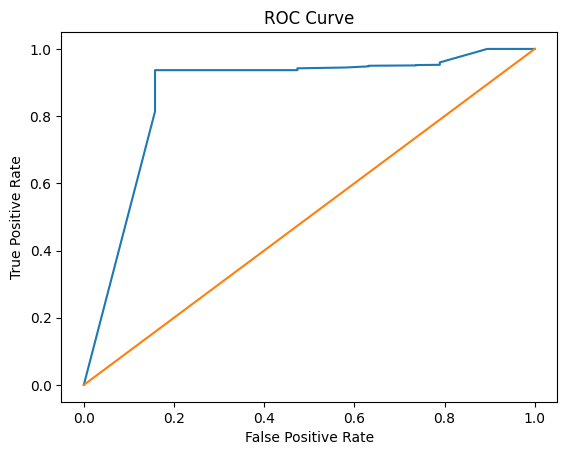

In [48]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true_clean, y_prob_clean)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

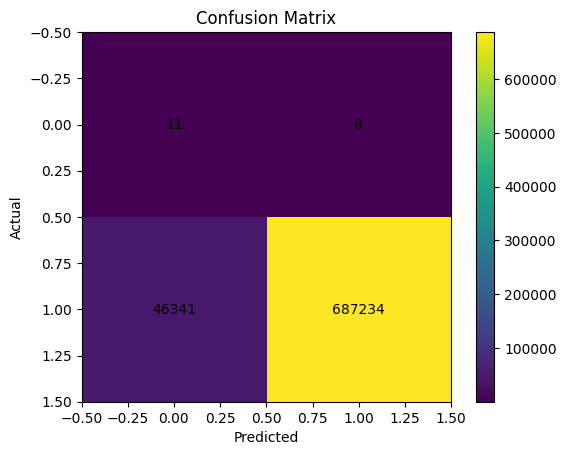

In [49]:
cm = confusion_matrix(y_true_clean, (y_prob_clean > 0.5))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()

In [20]:
train_dataset = build_pipeline("train.csv")
test_dataset  = build_pipeline("test.csv")

In [56]:
model2 = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(WINDOW,NUM_FEATURES)),
        MaxPooling1D(2),
        GRU(64),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

for x, y in train_dataset.take(1):
    print("X:", x.shape)
    print("Y:", y.shape)

history = model2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5
)

/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


X: (64, 20, 63)
Y: (64,)
Epoch 1/5
  45857/Unknown 1438s 31ms/step - accuracy: 0.9998 - loss: 0.0016 - precision_3: 0.9998 - recall_3: 0.9999

2026-02-24 23:25:23.846800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14580744094610481656
/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1780s 39ms/step - accuracy: 0.9999 - loss: 8.2321e-04 - precision_3: 0.9999 - recall_3: 1.0000 - val_accuracy: 1.0000 - val_loss: 7.0708e-05 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 2/5


2026-02-24 23:31:05.425381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14532105072682848152


45850/45857 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9997 - loss: 0.0016 - precision_3: 0.9998 - recall_3: 0.9999

2026-02-24 23:55:02.785244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8375774565513987369
2026-02-24 23:55:02.785271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14580744094610481656
2026-02-24 23:55:02.785288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7651836126360447972


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1784s 39ms/step - accuracy: 0.9998 - loss: 0.0010 - precision_3: 0.9999 - recall_3: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.6253e-05 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 3/5


2026-02-25 00:00:49.455389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9456047712053300120
2026-02-25 00:00:49.455410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14532105072682848152


45850/45857 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9997 - loss: 0.0014 - precision_3: 0.9998 - recall_3: 0.9999

2026-02-25 00:27:13.138359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8375774565513987369
2026-02-25 00:27:13.138993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14580744094610481656
2026-02-25 00:27:13.139230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7651836126360447972


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1938s 42ms/step - accuracy: 0.9998 - loss: 9.4381e-04 - precision_3: 0.9999 - recall_3: 1.0000 - val_accuracy: 1.0000 - val_loss: 7.2543e-05 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 4/5


2026-02-25 00:33:07.910445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4354378132037575068
2026-02-25 00:33:07.910466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9456047712053300120
2026-02-25 00:33:07.910471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14532105072682848152


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1825s 40ms/step - accuracy: 0.9998 - loss: 8.4316e-04 - precision_3: 0.9999 - recall_3: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.9632e-05 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 5/5


2026-02-25 01:03:33.321234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9456047712053300120
2026-02-25 01:03:33.321252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14532105072682848152


45855/45857 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9998 - loss: 0.0010 - precision_3: 0.9999 - recall_3: 1.0000

2026-02-25 01:28:08.056482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14580744094610481656


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1832s 40ms/step - accuracy: 0.9999 - loss: 7.5377e-04 - precision_3: 0.9999 - recall_3: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.3089e-05 - val_precision_3: 1.0000 - val_recall_3: 1.0000


2026-02-25 01:34:04.822309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4354378132037575068
2026-02-25 01:34:04.822342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9456047712053300120
2026-02-25 01:34:04.822348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14532105072682848152


In [21]:
model2.save('iot_model_cnngru.keras')

In [22]:
model2 = tf.keras.models.load_model('iot_model_cnngru.keras')

In [23]:
model2.evaluate(test_dataset)

2026-02-25 05:29:56.474406: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900


10759/10759 ━━━━━━━━━━━━━━━━━━━━ 290s 27ms/step - accuracy: 1.0000 - loss: 2.3089e-05 - precision_3: 1.0000 - recall_3: 1.0000


2026-02-25 05:34:45.543163: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-25 05:34:45.543198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4365467854399019987
2026-02-25 05:34:45.543207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 444388099623938556
2026-02-25 05:34:45.543210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3246116678942176204
/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[2.308888542756904e-05,
 0.9999956488609314,
 0.999997079372406,
 0.9999985694885254]

In [ ]:
WINDOW = 20
BATCH_SIZE = 100000  # rows per chunk

y_true_all = []
y_pred_all = []
y_prob_all = []

offset = 0

while True:
    chunk = (
        pl.scan_csv("test.csv")
        .slice(offset, BATCH_SIZE)
        .collect(streaming=True)
    )
    
    if chunk.height == 0:
        break
    
    X = chunk.select(FEATURE_COLS).to_numpy().astype(np.float32)
    y = chunk[LABEL_COL].to_numpy().astype(np.float32)
    
    num_windows = len(X) // WINDOW
    if num_windows == 0:
        break
    
    X = X[:num_windows * WINDOW]
    y = y[:num_windows * WINDOW]
    
    X_seq = X.reshape(num_windows, WINDOW, -1)
    y_seq = y.reshape(num_windows, WINDOW)
    y_final = y_seq[:, -1]
    
    y_pred_prob = model2.predict(X_seq, batch_size=64, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    y_true_all.extend(y_final)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_pred_prob.flatten())
    
    offset += BATCH_SIZE

print(classification_report(y_true_all, y_pred_all))

/tmp/ipykernel_32622/1529727623.py:16: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


              precision    recall  f1-score   support

         0.0       0.00      0.79      0.00        19
         1.0       1.00      0.91      0.95    733682

    accuracy                           0.91    733701
   macro avg       0.50      0.85      0.48    733701
weighted avg       1.00      0.91      0.95    733701



In [59]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

print("NaNs in y_true:", np.isnan(y_true).sum())
print("NaNs in y_prob:", np.isnan(y_prob).sum())

print("Inf in y_prob:", np.isinf(y_prob).sum())

y_true shape: (733701,)
y_prob shape: (733701,)
NaNs in y_true: 0
NaNs in y_prob: 65919
Inf in y_prob: 0


In [60]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

mask = ~np.isnan(y_prob)

y_true_clean = y_true[mask]
y_prob_clean = y_prob[mask]

print("Removed NaN samples:", len(y_true) - len(y_true_clean))

auc_score = roc_auc_score(y_true_clean, y_prob_clean)
print("ROC-AUC Score:", auc_score)

Removed NaN samples: 65919
ROC-AUC Score: 0.5995371209250993


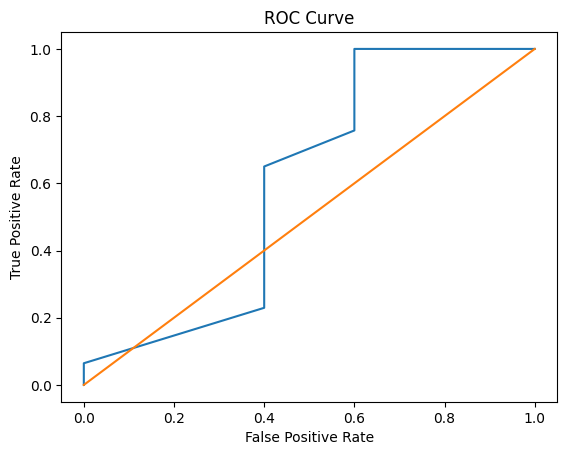

In [61]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true_clean, y_prob_clean)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

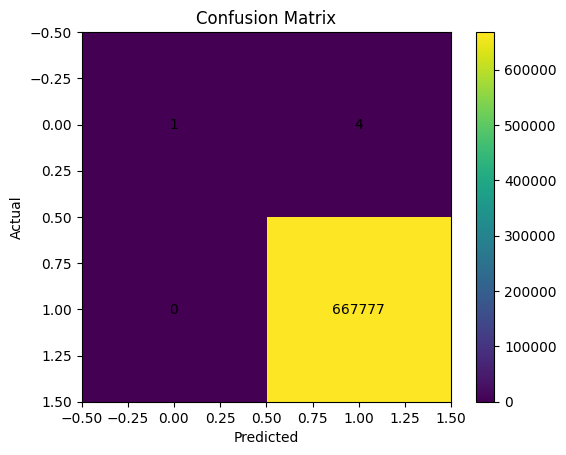

In [62]:
cm = confusion_matrix(y_true_clean, (y_prob_clean > 0.5))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()